# Fixed Income 101
Let us define a Bond as a class object that has 3 fundamental initialization properties: (1) Principal, (2) Coupon and (3) Time to Maturity (TTM)

<u> Associated functions: </u><br>
<b>getPrice:</b> Computes price of the bond given a Yield to Maturity (ytm) <br> 
<b>getYTM:</b> Back calculates the Yield to Maturity for a given price of the Bond. Uses Newton's method (Secent Method) to solve for the roots of the equation <br>
<b>estimateModifiedDuration:</b> From price changes for a 1% change in yield <br>
<b>estimateConvexity: </b> Second derivative, again for a 1% change in yield 


In [1]:
import scipy.optimize as optimize
import math

class Bond:
    
    def __init__(self, principal, coupon, ttm):
        self.principal = principal
        self.coupon = coupon
        self.ttm = ttm
        
    def getPrice(self, ytm):
        
        ttm = self.ttm #doesnt
        price = self.principal/(1+ytm)**ttm
        for i in range(math.ceil(ttm),0,-1):
            price += self.coupon/(1+ytm)**ttm
            ttm -= 1
            
        return price
        
    def getYTM(self,price):
        
        f = lambda x: price - self.getPrice(x)
        
        return optimize.newton(f,0.05)
    
    def estimateModifiedDuration(self, ytm):
        
        change = self.getPrice(ytm-0.01) - self.getPrice(ytm+0.01)
        base = self.getPrice(ytm)
        
        return change/(2*base)/0.01
    
    def estimateConvexity(self, ytm):
        
        base = self.getPrice(ytm)
        change = self.getPrice(ytm-0.01) + self.getPrice(ytm+0.01) - 2*base
        
        return change/base/0.01**2

## Part A. Price vs Yield Relationship

Using the Bond class defination, we define __four bonds__ as:
1. Short Duration Bond (sdBond) maturing in 1 year
2. Medium Duration Bond (mdBond) maturing in 5 years
3. Long Duration Bond (ldBond) maturing in 10 years
4. Very Long Duration Bond (vldBond) maturing in 30 years

Each Bond has a Principal of 100 and Coupon of 5

In [2]:
sdBond = Bond(principal = 100, coupon = 5, ttm = 1)
mdBond = Bond(100,5,ttm = 5)
ldBond = Bond(100,5,ttm = 10)
vldBond = Bond(100,5,ttm = 30)

In [3]:
import numpy as np
#Computing the Bond price for yields at 0% to 10% using Discounted Cash Flows
x = np.linspace(0,0.1,101)
sd = [sdBond.getPrice(i) for i in x]
md = [mdBond.getPrice(i) for i in x]
ld = [ldBond.getPrice(i) for i in x]
vld = [vldBond.getPrice(i) for i in x]

### Duration and Convexity

Approximating the Modified Duration using the formula:

$$Modified Duration = \frac {(PV_- PV_+)}{2 * PV_0 * \Delta Yield}$$

<br>Approximating the Convexity using the formula:

$$ Convexity = \frac {(PV_-) + (PV_+) - 2*(PV_0)}{(PV_0) * (\Delta Yield)^2}$$

In [4]:
# Computing the Duration and Convexity at 5% yield
sdDuration = sdBond.estimateModifiedDuration(0.05)
mdDuration = mdBond.estimateModifiedDuration(0.05)
ldDuration = ldBond.estimateModifiedDuration(0.05)
vldDuration = vldBond.estimateModifiedDuration(0.05)

sdConvexity = sdBond.estimateConvexity(0.05)
mdConvexity = mdBond.estimateConvexity(0.05)
ldConvexity = ldBond.estimateConvexity(0.05)
vldConvexity = vldBond.estimateConvexity(0.05)

### Plotting using Matplotlib's Scripting Layer

In [5]:
import matplotlib.pyplot as plt

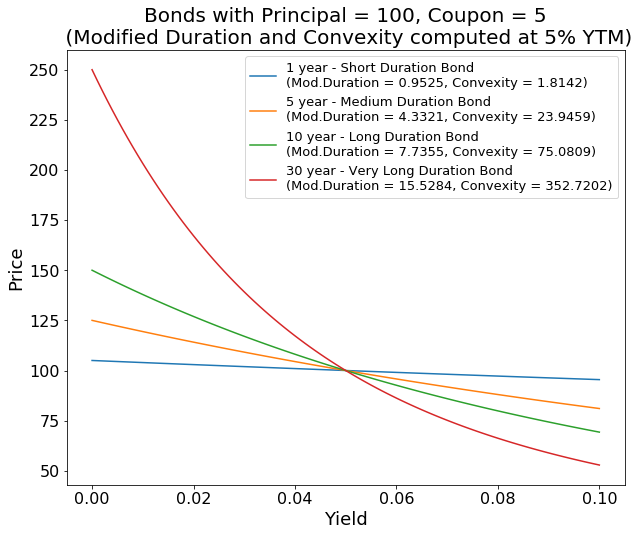

In [6]:
plt.figure(figsize = (10,8))
plt.plot(x,sd, label = '{:d} year - Short Duration Bond \n(Mod.Duration = {:3.4f}, Convexity = {:3.4f})'.format(sdBond.ttm,sdDuration,sdConvexity))
plt.plot(x,md, label = '{:d} year - Medium Duration Bond \n(Mod.Duration = {:3.4f}, Convexity = {:3.4f})'.format(mdBond.ttm,mdDuration,mdConvexity))
plt.plot(x,ld, label = '{:d} year - Long Duration Bond \n(Mod.Duration = {:3.4f}, Convexity = {:3.4f})'.format(ldBond.ttm,ldDuration,ldConvexity))
plt.plot(x,vld, label = '{:d} year - Very Long Duration Bond \n(Mod.Duration = {:3.4f}, Convexity = {:3.4f})'.format(vldBond.ttm,vldDuration,vldConvexity))
plt.legend(fontsize=13)
plt.xlabel('Yield',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Bonds with Principal = 100, Coupon = 5\n (Modified Duration and Convexity computed at 5% YTM)',fontsize=20)
plt.show()

### Observations
1. The inverse Price-Yield relationship - Lower (Higher) the yield, Higher (Lower) the Price
2. The inverse Price-Yield Relationship gets steeper for longer duration bonds
3. Bond Convexity increases with the increase in bond maturity

## Part B. Bonds with Same Duration

Now, we consider the price behaviour of bonds with same durations. For this, defining two bonds:

1. Low Convexity Bond (lcBond)
2. High Convexity Bond (hcBond)

Note that these bonds are supposed to have same Durations. To match the durations, we define lcBond as a zero coupon 15 year bond and solve for hcBond parameters that match the durations of the two bonds.

For this, we define a function bondDurationMatcher that returns the difference in the durations of two bonds (at 5% YTM). We then solve for the time to maturity of hcBond (using Scipy's Newton/Secent method) for which the difference in duration of the two bonds is zero.

In [7]:
lcBond = Bond(principal = 100,coupon = 0,ttm = 15)

In [8]:
def bondDurationMatcher(x):
    b = Bond(100,10,x)
    return b.estimateModifiedDuration(0.05) - lcBond.estimateModifiedDuration(0.05)

In [9]:
hcBond = Bond(principal = 100,coupon = 10, ttm = optimize.newton(bondDurationMatcher,2))
print("High Convexity Bond's computed Time to Maturity = {:4.2f} years".format(hcBond.ttm))

High Convexity Bond's computed Time to Maturity = 35.28 years


In [10]:
#Summary of bond properties at 5% YTM
print('Bond\t\t\tTTM\t\tDuration\tConvexity\tPrice')
print('\nLow Convexity\t\t{:4.2f}\t\t{:4.2f}\t\t{:4.2f}\t\t{:6.2f}'.format(lcBond.ttm,
                                                                      lcBond.estimateModifiedDuration(0.05),
                                                                      lcBond.estimateConvexity(0.05),
                                                                      lcBond.getPrice(0.05)))

print('\nHigh Convexity\t\t{:4.2f}\t\t{:4.2f}\t\t{:4.2f}\t\t{:6.2f}'.format(hcBond.ttm,
                                                                      hcBond.estimateModifiedDuration(0.05),
                                                                      hcBond.estimateConvexity(0.05),
                                                                      hcBond.getPrice(0.05)))
      


Bond			TTM		Duration	Convexity	Price

Low Convexity		15.00		14.34		218.19		 48.10

High Convexity		35.28		14.34		333.07		189.24


Thus, the Duration of both the bonds are equal. However, the price of the two bonds are different. For Price-Yield relationship, we will compare 1 unit of lcBond with (lcBond Price/hcBond Price) units of hcBond

In [11]:
priceRatio = lcBond.getPrice(0.05)/hcBond.getPrice(0.05)
print('Thus we require {:2.4f} High Convexity Bonds for each Low Convexity Bond'.format(priceRatio))
lc = [lcBond.getPrice(i) for i in x]
hc = [priceRatio*hcBond.getPrice(i) for i in x]

Thus we require 0.2542 High Convexity Bonds for each Low Convexity Bond


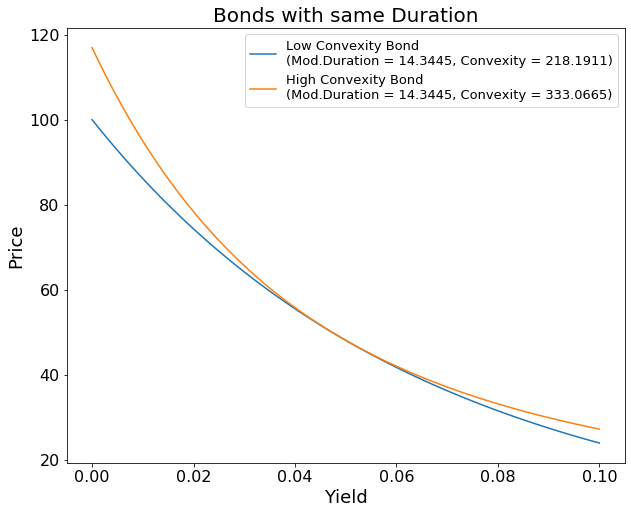

In [12]:
plt.figure(figsize = (10,8))
plt.plot(x,lc,label = 'Low Convexity Bond \n(Mod.Duration = {:3.4f}, Convexity = {:3.4f})'
         .format(lcBond.estimateModifiedDuration(0.05),lcBond.estimateConvexity(0.05)))
plt.plot(x,hc,label = 'High Convexity Bond \n(Mod.Duration = {:3.4f}, Convexity = {:3.4f})'
         .format(hcBond.estimateModifiedDuration(0.05),hcBond.estimateConvexity(0.05)))
plt.legend(fontsize=13)
plt.xlabel('Yield',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Bonds with same Duration',fontsize=20)
plt.show()

### Observation

Impact of high convexity on the Bond price. From the Same Duration and Same Price point at 5% YTM:

* For increase in yield, the high Convexity Bond suffers less price reduction than the Low Convexity Bond 
* For decrease in yield, the high Convexity Bond gets a higher price increase than the Low Convexity Bond

## Part C. Predicting price from Duration and Convexity

For small changes in YTM, bond prices can be predicted using Duration and Convexity measures.

**Duration** only captures a linear relationship in the change in price:

$$\Delta PV_{Duration} = -ModifiedDuration * \Delta Yield$$

<br>Including a second order **Convexity** term allows for a better prediction

$$\Delta PV_{Convexity} = (-ModifiedDuration * \Delta Yield) + (\frac {1}{2} * Convexity * (\Delta Yield)^2)$$

In [13]:
predDuration = [(1-vldDuration*(i-0.05))*vldBond.getPrice(0.05) for i in x]
predConvexity = [(1-vldDuration*(i-0.05)+0.5*vldConvexity*(i-0.05)**2)*vldBond.getPrice(0.05) for i in x]

In [14]:
print('YTM\t\tActual Price\tFrom Duration\tFrom Duration & Convexity')
for i in range(11):
    print('{:d}%\t\t{:5.2f}\t\t{:5.2f}\t\t{:5.2f}'.format(int(x[i*10]*100),vld[i*10],predDuration[i*10],predConvexity[i*10]))

YTM		Actual Price	From Duration	From Duration & Convexity
0%		250.00		177.64		221.73
1%		203.23		162.11		190.33
2%		167.19		146.59		162.46
3%		139.20		131.06		138.11
4%		117.29		115.53		117.29
5%		100.00		100.00		100.00
6%		86.24		84.47		86.24
7%		75.18		68.94		76.00
8%		66.23		53.41		69.29
9%		58.91		37.89		66.10
10%		52.87		22.36		66.45


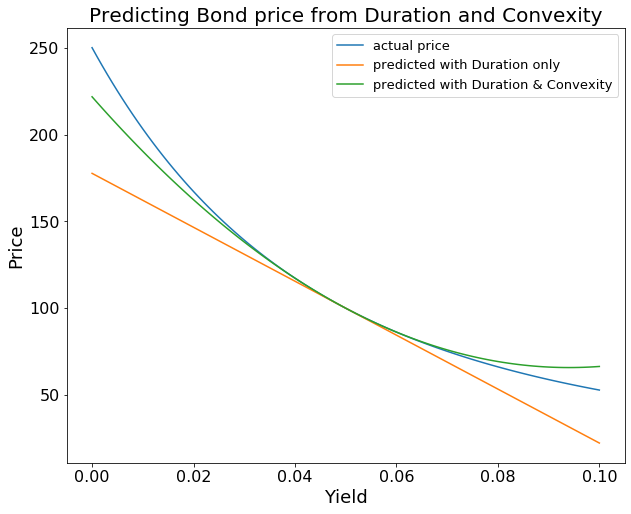

In [15]:
plt.figure(figsize = (10,8))
plt.plot(x,vld,label = 'actual price') #actual
plt.plot(x,predDuration,label = 'predicted with Duration only')
plt.plot(x,predConvexity,label = 'predicted with Duration & Convexity')
plt.legend(fontsize=13)
plt.xlabel('Yield',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Predicting Bond price from Duration and Convexity',fontsize=20)
plt.show()

### Observation
The Duration and Convexity measures are much better predictors of the actual bond price